# Material models

When we solve the mechanical model, we are solving for an equilibrium of stresses. Here, both active and passive tension plays in, as well as boundary conditions. The passive tension is determined by a strain energy function, which again depends on certain material parameters.

In an earlier demo we demonstrated how to perform virtual stretch and shear experiments. In this repo, we'll redo the stretch experiment – and compare two material models; one Guccione kind of model, and one Holzapfel kind of model. Note that the Holzapfel model is fitted with experimental data, while the Guccione model is simply adjusted to be "about as stiff". Both assume a transversely isotropic formulation in the intracellular subdomain, and an isotropic formulation for the extracellular subdomain.

We will use the code from the main repository [emimechanicalmodel](https://github.com/aashildte/emimechanicalmodel/), which is based on FEniCS. We can import all libraries we need in this demo, and load the meshes and subdomains:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

mesh_file = "tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## The strain energy functions

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We can write

$$\Psi = \Psi_{active} + \Psi_{passive} + \Psi_{incompressible}$$

and then define $\mathbf{P}$ based on $\Psi$ and the deformation tensor $\mathbf{F}$. See the previous chapter (or the papers) for the mathematical details.

In this chapter we'll focus on $\Psi_{passive}$, which we can separate it into two separate contributions:

$$ \Psi_{passive} (F) = \begin{cases} \Psi_{i} (F) \qquad x \in \Omega_i \\ \Psi_{e} (F) \qquad x \in \Omega_e \end{cases} $$

### Guccione model

We have adapted a traditional Guccione model (or a Fung model) to the EMI framework, by defining two strain energy functions, one for each subdomain. For this, we use components of the Cauchy-Green strain tensor $\mathbf{E}$.

$$ \Psi_i = C_i (e^{Q_i} - 1)$$

The parameter $C_i$ has unit kPa, and adjusting will adjust the stiffness of the cell. Furthermore, the term $Q_i$ determines the exponential behavior of increasing amounts of strain:

$$ Q_i = b_{f, i} E_{11}^{2} + b_{t, i}(E_{22}^{2} + E_{33}^{2} + E_{23}^{2} + E_{32}^{2}) + b_{ft, i}(E_{12}^{2} + E_{21}^{2} + E_{13}^{2} + E_{31}^{2}) $$

The exponential ("b") parameters determine the ratio between the fiber direction ($b_{f, i}$), the transverse direction ($b_{t, i}$) and the transverse direction ($b_{ft, i}$). If they are all equal, the material can be called _isotropic_.

Next, for the extracellular space, we will use

$$ \Psi_e = C_e (e^{Q_e} - 1)$$

where

$$ Q_e = b_e (E_{11}^{2} + E_{22}^{2} + E_{33}^{2} + E_{23}^{2} + E_{32}^{2}) + E_{12}^{2} + E_{21}^{2} + E_{13}^{2} + E_{31}^{2}) $$

Mathematically, this term is equal to $Q_i$ but with all parameters equal to $b_e$. Mechanically, this implies that the material is isotropic with material properties determined by $C_e$ and $b_e$.

### Holzapfel model

As for the Guccione kind of model, we define separate strain energy functions $\Psi_i$ and $\Psi_e$. The Holzapfel model is _invariant-based_. It is, arguably, less advanced than a traditional Holzapfel model, in terms of only taking into account two.

We first define the right Cauchy-Green tensor (in fact, $\mathbf{E}$ is usually defined based on $\mathbf{C}$)

$$ \mathbf{C} = \mathbf{F}^T \mathbf{F} $$

then we have

$$
        I_1 = \mathrm{tr} (\mathbf{C})     \label{eq:intro:I_1}  \\
$$

and 

$$
        I_{4, f} = \mathbf{f} \cdot (\mathbf{C} \mathbf{f})     \label{eq:intro:I_4e1} \\
$$      

where $I_{4, f}$ simply quantiifes the change in the fiber direction. Next, we define

$$
    \psi(\mathbf{F}) = \frac{a_i}{2 b_i} (e^{b_i (I_1 - 3)} - 1) + \frac{a_{if}}{2 b_{if}} (e^{b_{if} \| I_{4f} - 1 \|_{+}^2} - 1)
$$

where $\| \cdot \|_{+}$ is a conditional term given by $\| I \|_{+} = \mathrm{max}(I, 0)$ (i.e., 0 if $I$ is below zero). For the extracellular subdomain, we define

$$
    \psi_{e}(\mathbf{F}) = \frac{a_e}{2 b_e} (e^{b_e (I_1 - 3)} - 1).
$$


## Stretching and active contraction

We have two material models – both based on well-known, widely used traditional tissue-level models. They are fairly interchangable, but not equal – note that this is, in parts, due to that the Guccione model has not been parametrized in a rigorous way. We'll compare stretch in different directions and contraction values, tracking load values for the stretching experiments and intracellular fiber direction strain and stress values for the contraction experiments.

length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0


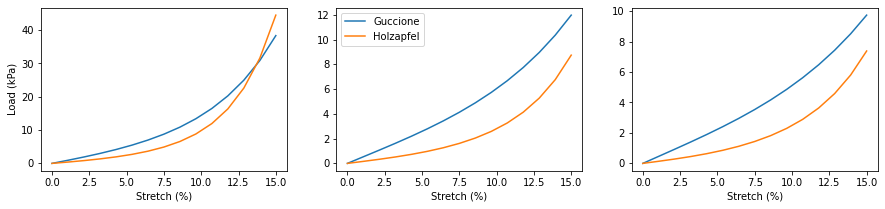

In [8]:
material_models = ["guccione", "holzapfel"]
experiments = ["stretch_ff", "stretch_ss", "stretch_nn"]

stretch_values = np.linspace(0, 0.15, 15)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for material_model in material_models:

    for experiment, axis in zip(experiments, axes):
        emimodel = emi_m.EMIModel(
                mesh,
                volumes,
                experiment=experiment,
                material_model=material_model,
            )

        load_values = np.zeros_like(stretch_values)

        # then run the simulation
        for step, s_str in enumerate(stretch_values):
            emimodel.assign_stretch(s_str)
            emimodel.solve()

            load_values[step] = \
                emimodel.evaluate_normal_load()

        axis.plot(100*stretch_values, load_values)

axes[0].set_xlabel("Stretch (%)")
axes[1].set_xlabel("Stretch (%)")
axes[2].set_xlabel("Stretch (%)")
axes[0].set_ylabel("Load (kPa)")

axes[1].legend(["Guccione", "Holzapfel"])

plt.show()

### Contraction

length=102.0, width=20.0, height=24.0
length=102.0, width=20.0, height=24.0


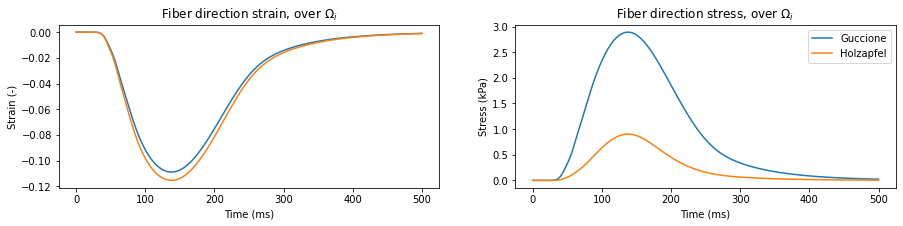

In [10]:
time = np.linspace(0, 500, 125)       # 500 ms with 125 steps
active_precomputed = emi_m.compute_active_component(time)

material_models = ["guccione", "holzapfel"]

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

for material_model in material_models:
    emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            material_model=material_model,
        )

    fiber_dir_strain_i = np.zeros_like(active_precomputed)
    fiber_dir_stress_i = np.zeros_like(active_precomputed) 
    subdomain_id = 1         # intracellular subdomain

    # then run the simulation
    for step, a_str in enumerate(active_precomputed):
        emimodel.update_active_fn(a_str)
        emimodel.solve()

        fiber_dir_strain_i[step] = \
            emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
        fiber_dir_stress_i[step] = \
            emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)

    axes[0].plot(time, fiber_dir_strain_i)
    axes[1].plot(time, fiber_dir_stress_i)

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

axes[1].legend(["Guccione", "Holzapfel"])

plt.show()